In [92]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


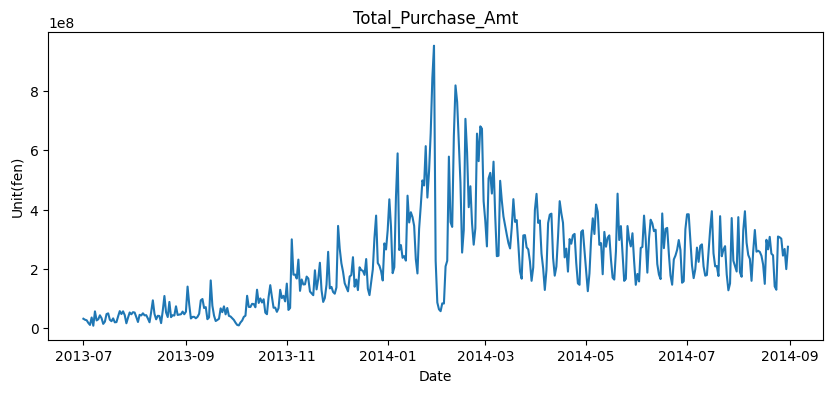

In [93]:
#数据预处理
user_balance = pd.read_csv('./Data/Purchase Redemption Data/user_balance_table.csv')

#以日期为索引，对每个日期的申购和赎回金额进行求和
df_temp = user_balance.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()

#重新生成索引
df_temp.reset_index(inplace=True)

#修改日期格式，方便对日期进行选择和切片
df_temp['report_date'] = pd.to_datetime(df_temp['report_date'],format='%Y%m%d')
df_temp.index = df_temp['report_date']

total_purchase_amt = plt.figure(figsize=(10,4))
ax = total_purchase_amt.add_subplot(111)
ax.set(title='Total_Purchase_Amt',ylabel='Unit(fen)', xlabel='Date')
plt.plot(df_temp['report_date'],df_temp['total_purchase_amt'])
plt.show()

In [94]:
def generate_purchase_seq():
    dateparse = lambda dates:pd.datetime.strptime(dates,'%Y%m%d')
    user_balance = pd.read_csv('./Data/Purchase Redemption Data/user_balance_table.csv',parse_dates=['report_date'],index_col=['report_date'],date_parser=dateparse)

    df = user_balance.groupby(['report_date'])['total_purchase_amt'].sum()
    #转成序列
    purchase_seq = pd.Series(df,name='value')

    #切分出训练集和测试集
    purchase_seq_train = purchase_seq['2014-04-01':'2014-07-31']
    purchase_seq_test = purchase_seq['2014-08-01':'2014-08-31']

    purchase_seq_train.to_csv('./Data/Purchase Redemption Data/total_purchase_train.csv',header=True)
    purchase_seq_test.to_csv('./Data/Purchase Redemption Data/total_purchase_test.csv',header=True)

generate_purchase_seq()

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


timeseries_adf :  (-2.0639747511769864, 0.25924499643351684, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4191.005978668395)
timeseries_diff1_adf :  (-6.542516143607563, 9.270661450976566e-09, 12, 109, {'1%': -3.49181775886872, '5%': -2.8884437992971588, '10%': -2.5811201893779985}, 4193.843107210291)
timeseries_diff2_adf :  (-5.6155458674545145, 1.1766955956627649e-06, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4222.922633673087)


c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


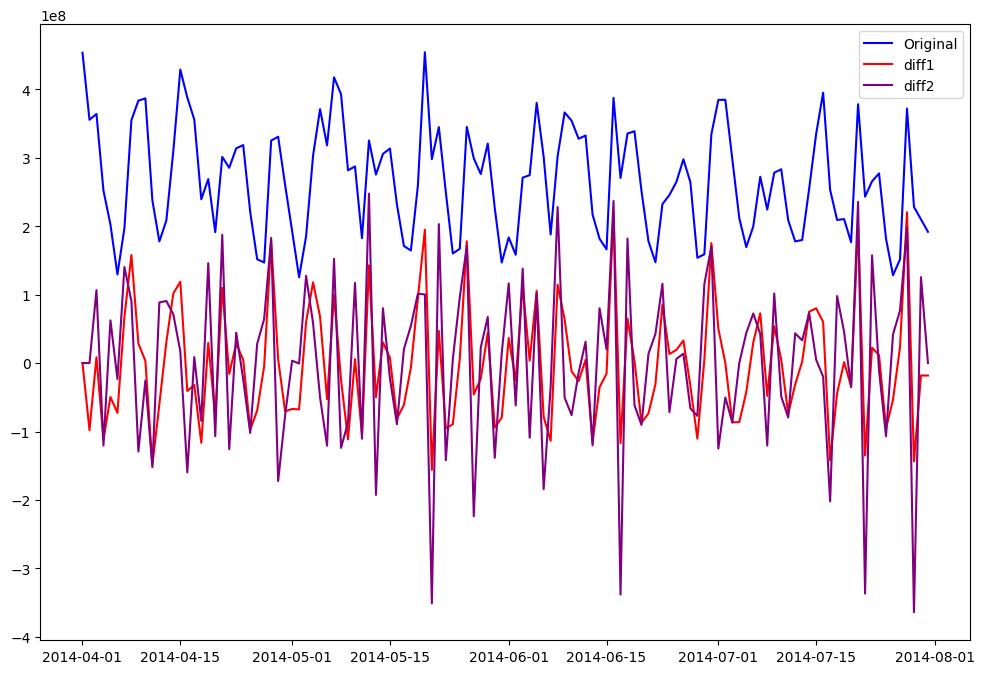

In [95]:
def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries['value'].tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1['value'].tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2['value'].tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12,8))
    plt.plot(timeseries,label='Original',color='blue')
    plt.plot(timeseries_diff1,label='diff1',color='red')
    plt.plot(timeseries_diff2,label='diff2',color='purple')
    plt.legend(loc='best')
    plt.show()

def diffx(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries)
    timeseries_diff1_adf = ADF(timeseries_diff1)
    timeseries_diff2_adf = ADF(timeseries_diff2)

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12,8))
    plt.plot(timeseries,label='Original',color='blue')
    plt.plot(timeseries_diff1,label='diff1',color='red')
    plt.plot(timeseries_diff2,label='diff2',color='purple')
    plt.legend(loc='best')
    plt.show()

dateparse = lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
purchase_seq_train = pd.read_csv('./Data/Purchase Redemption Data/total_purchase_train.csv',parse_dates=['report_date'],index_col=['report_date'],date_parser=dateparse)
diff(purchase_seq_train)


c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


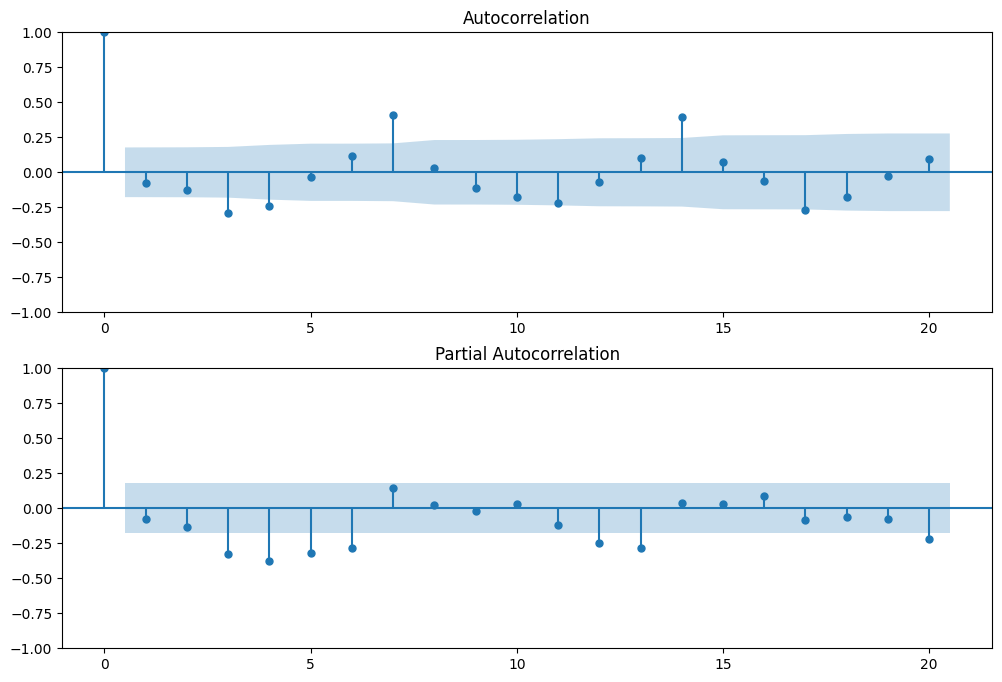

In [96]:
#根据上面输出的ADF值，我们可以看到，一阶差分后的数据，已经达到了99%的置信度
#所以我们使用一阶差分的数据来进行预测
#现在根据ACF与PACF指标来决定ARIMA模型的AR项数和MA项数
def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()

autocorrelation(purchase_seq_train.diff(1).fillna(0),20)

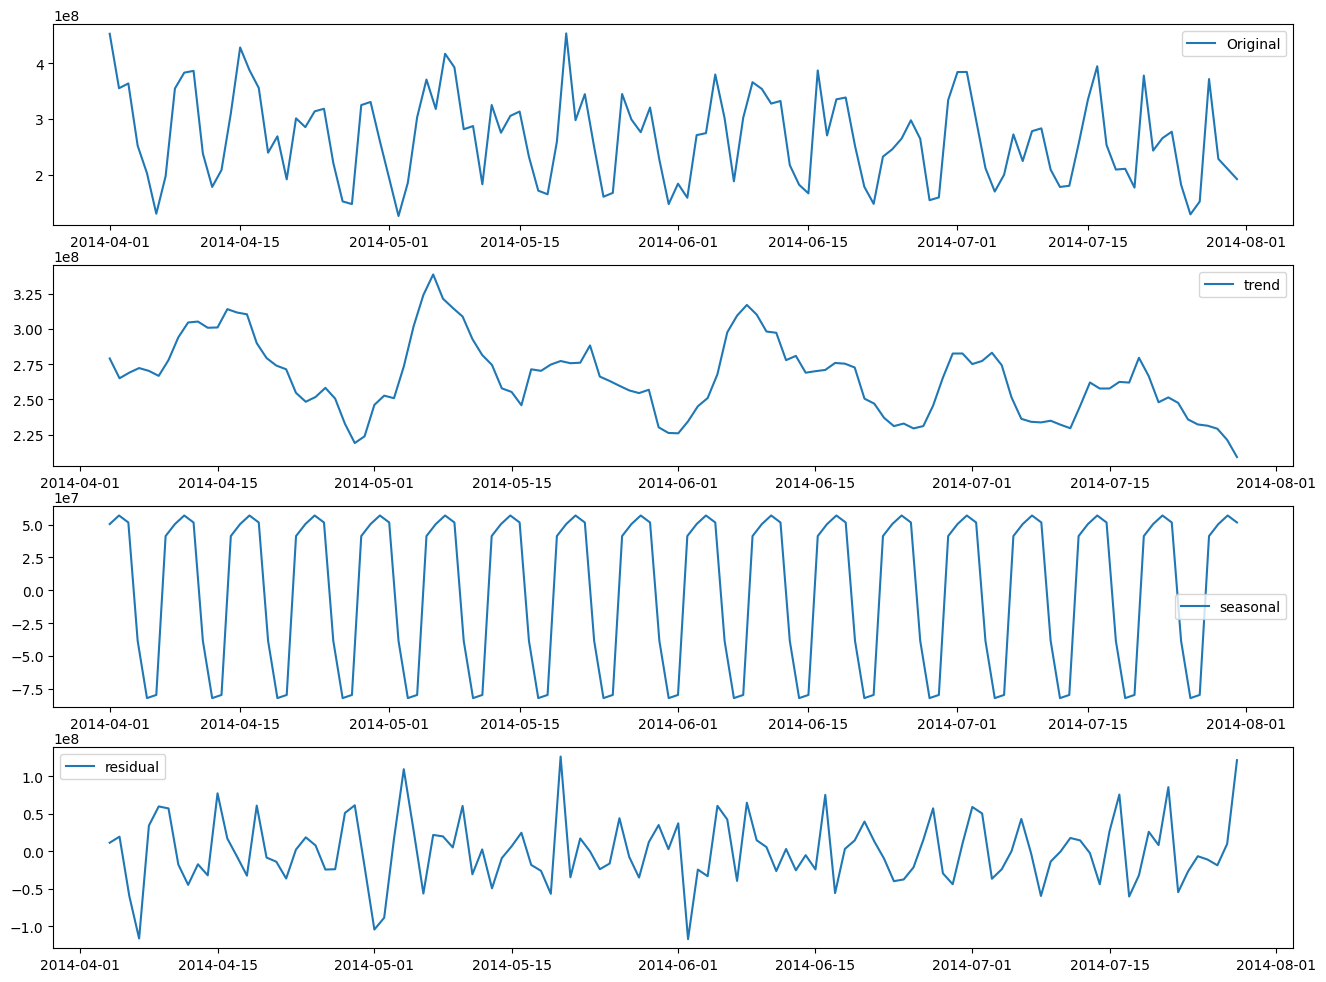

In [97]:
#由于ACF值与PACF的值没有出现明显的结尾和拖尾
#数据可能具有周期性
#这里对时间序列进行周期分解

def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16,12))
    plt.subplot(411)
    plt.plot(timeseries,label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend,label='trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual,label='residual')
    plt.legend(loc='best')
    plt.show()


decomposing(purchase_seq_train)

timeseries_adf :  (-3.2368487584485877, 0.017948383665881536, 0, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 3971.5751227480287)
timeseries_diff1_adf :  (-10.571816201699766, 7.2723798146224e-19, 0, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 3970.0252957725997)
timeseries_diff2_adf :  (-5.522044427904824, 1.868165478739749e-06, 8, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 3975.173191562041)


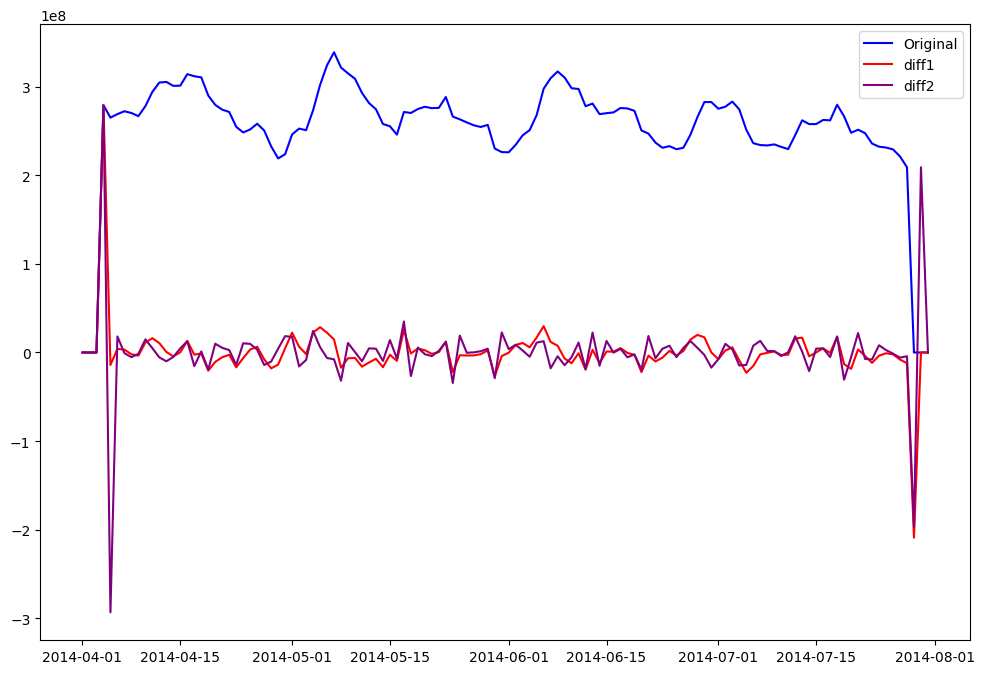

timeseries_adf :  (-6.290212104648347, 3.614727756796406e-08, 8, 113, {'1%': -3.489589552580676, '5%': -2.887477210140433, '10%': -2.580604145195395}, 4080.577975834708)
timeseries_diff1_adf :  (-5.903150268380962, 2.7477376300421066e-07, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4107.235275181308)
timeseries_diff2_adf :  (-6.644726878644943, 5.300796399128618e-09, 13, 108, {'1%': -3.4924012594942333, '5%': -2.8886968193364835, '10%': -2.5812552709190673}, 4137.527983157887)


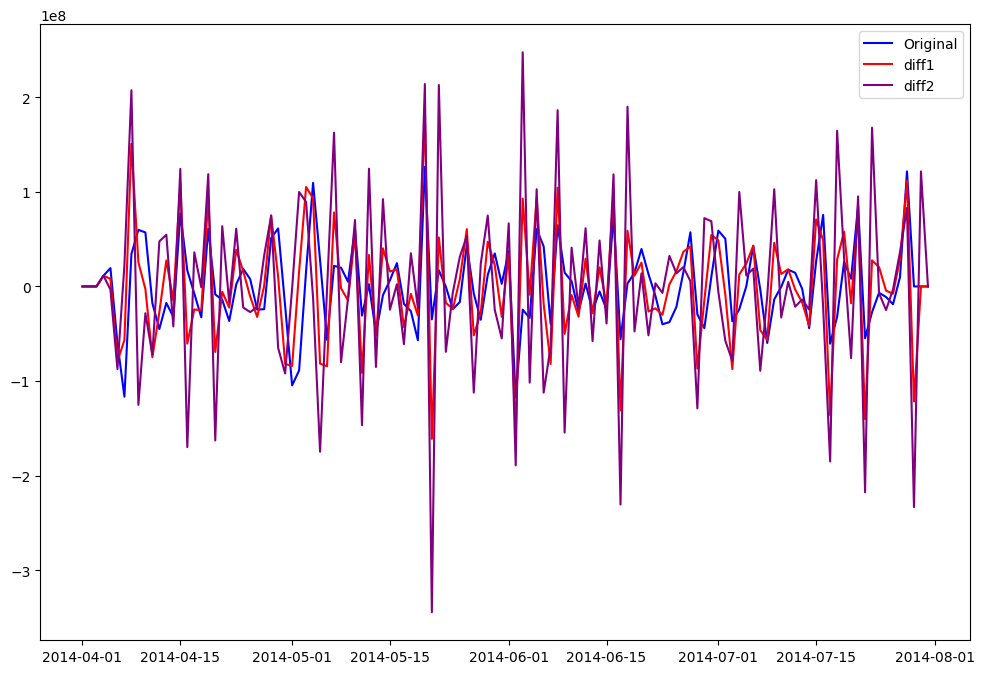

In [98]:
#从上图可以看出，原数据周期性明显，以七天为一个周期
#残差序列接近于白噪声
#那么，我们只需要对趋势数据和残差数据进行预测就可以了
#我们需要先对趋势分量和残差进行ADF检验，检查数据的平稳性
decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

diffx(trend)
diffx(residual)


c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


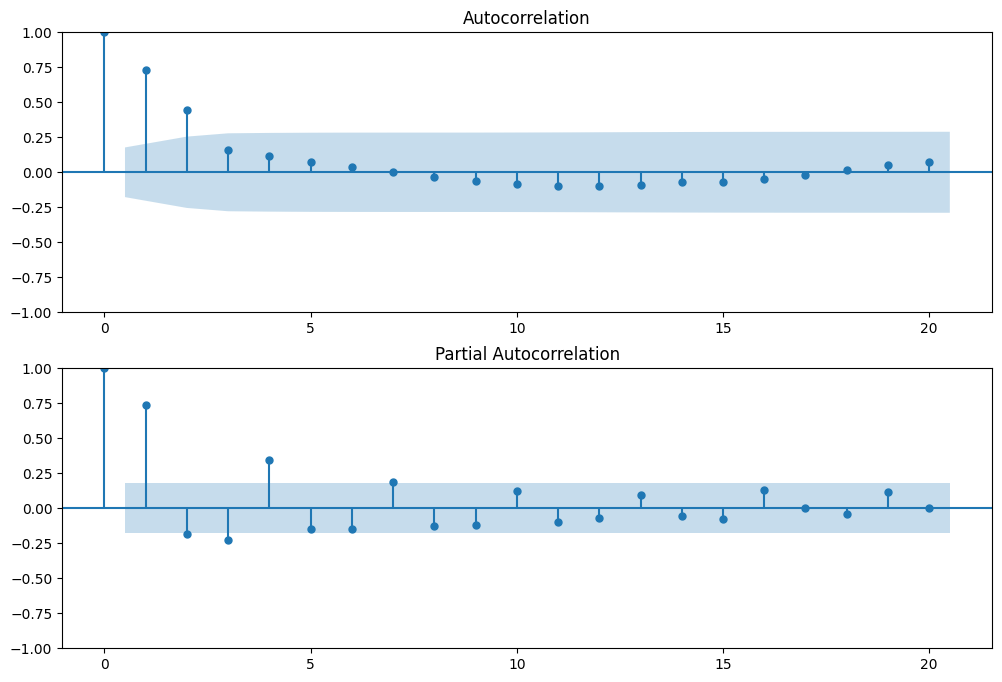

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


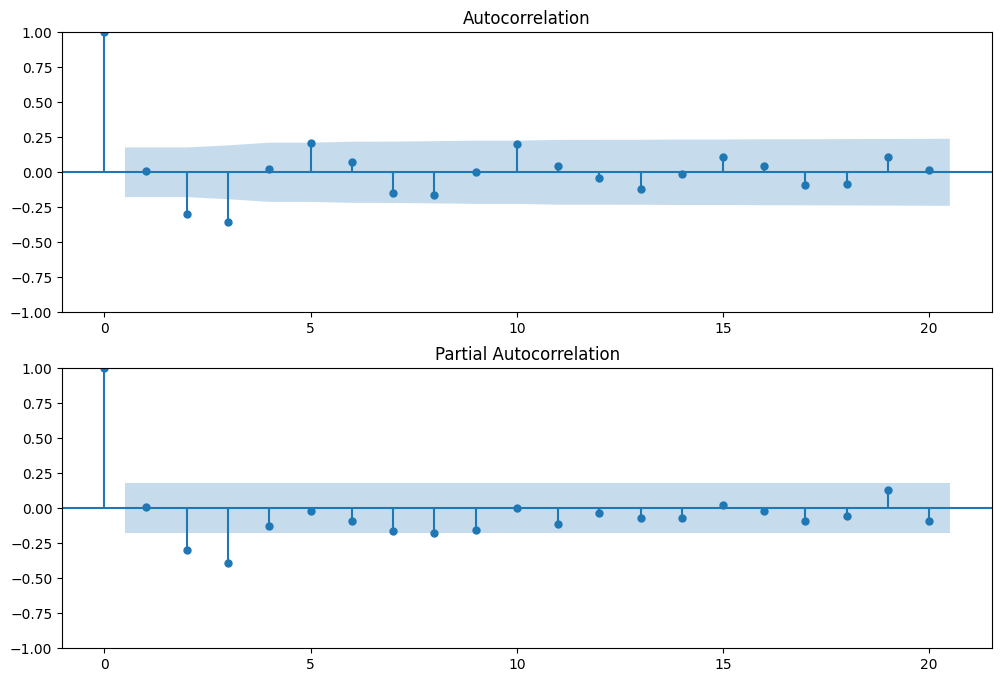

In [99]:
#由上面的ADF值可以看到，趋势序列已经达到了95%的置信度
#残差序列达到了99%的置信度，所以不需要再进行差分了
#在这里观察两个序列的ACF值和PACF值

autocorrelation(trend,20)
autocorrelation(residual,20)

In [100]:
#由上图可以看出
#趋势序列，ACF值在第2项后出现截尾，PACF在第1项后出现拖尾
#残差序列，ACF值在第3项之出现截尾，PACF在第3项之后出现截尾
#因此我们选择，趋势序列 p = 1, q = 2 原博客是 2， 3
#残差序列 p = 3, q = 3， 原博客是 4， 4
#可以再看看AIC 和 BIC

trend_evaluate = sm.tsa.arma_order_select_ic(trend,ic=['aic','bic'],max_ar=4,max_ma=4)
# print('trend AIC', trend_evaluate.aic_min_order)
# print('trend BIC', trend_evaluate.bic_min_order)

residual_evaluate = sm.tsa.arma_order_select_ic(residual,ic=['aic','bic'],max_ar=4,max_ma=4)
# print('residual AIC', residual_evaluate.aic_min_order)
# print('residual BIC', residual_evaluate.bic_min_order)

print('trend:',trend_evaluate)
print('residual',residual_evaluate)

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\stats

trend: {'aic':              0            1            2            3            4
0  5197.667065  4659.536992  4601.166559  4588.426211  4591.184022
1  4582.741416  4610.449562  4636.406917  4633.411077  4631.598094
2  4584.210633  4604.150725  4635.354428  4637.086871  4631.376341
3  4585.136110  4607.643921  4636.838983  4628.344798  4632.555496
4  4637.287274  4637.517132  4638.786781  4635.470863  4625.655507, 'bic':              0            1            2            3            4
0  5203.275107  4667.949055  4612.382643  4602.446317  4608.008148
1  4591.153480  4621.665646  4650.427022  4650.235204  4651.226241
2  4595.426717  4618.170831  4652.178554  4656.715018  4653.808509
3  4599.156215  4624.468048  4656.467130  4650.776966  4657.791686
4  4654.111400  4657.145279  4661.218949  4660.707053  4653.695717, 'aic_min_order': (1, 0), 'bic_min_order': (1, 0)}
residual {'aic':              0            1            2            3            4
0  5104.618500  4641.546579  4613.9513

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\statsmodels\base\model.py:606: 

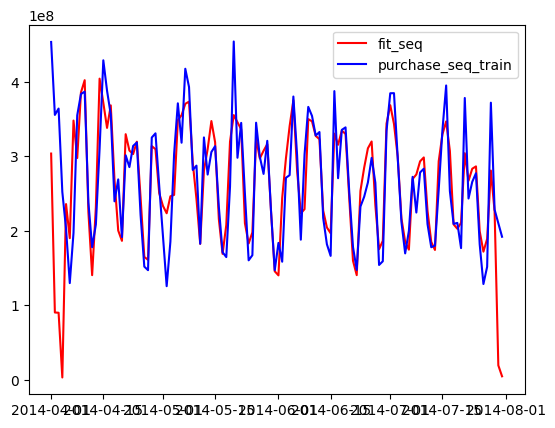

c:\ProgramData\Anaconda3\envs\pytorch_train\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


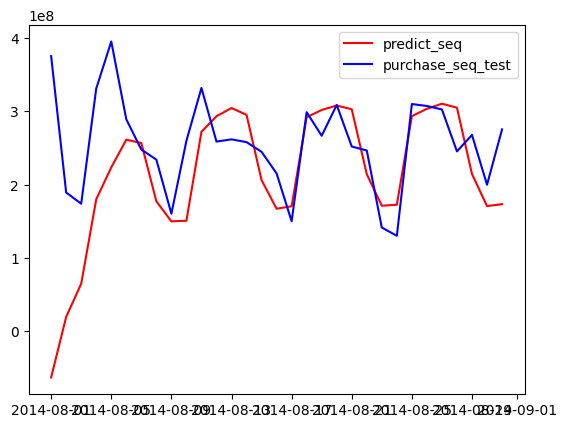

In [119]:
#由上面的输出结果，我们选择，1,0和2，1
def ARIMA_Model(timeseries,order):
    model = sm.tsa.arima.ARIMA(timeseries,order=order)
    return model.fit()

dateparse = lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
purchase_seq_train = pd.read_csv('./Data/Purchase Redemption Data/total_purchase_train.csv',parse_dates=['report_date'],index_col=['report_date'],date_parser=dateparse)

purchase_seq_test = pd.read_csv('./Data/Purchase Redemption Data/total_purchase_test.csv',parse_dates=['report_date'],index_col=['report_date'],date_parser=dateparse)

decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

# 趋势序列模型训练
trend_model = ARIMA_Model(trend, (3, 0, 3))
trend_fit_seq = trend_model.fittedvalues
trend_predict_seq = trend_model.predict(start='2014-08-01', end='2014-08-31', dynamic=True)

# 残差序列模型训练
residual_model = ARIMA_Model(residual, (3, 0, 3))
residual_fit_seq = residual_model.fittedvalues
residual_predict_seq = residual_model.predict(start='2014-08-01', end='2014-08-31', dynamic=True)

# 拟合训练集
fit_seq = pd.Series(seasonal, index=seasonal.index)
fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

plt.plot(fit_seq, color='red', label='fit_seq')
plt.plot(purchase_seq_train, color='blue', label='purchase_seq_train')
plt.legend(loc='best')
plt.show()

seasonal_predict_seq = seasonal['2014-04-04':'2014-05-04']

predict_dates = pd.Series(
    ['2014-08-01', '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05', '2014-08-06', '2014-08-07', '2014-08-08',
     '2014-08-09', '2014-08-10', '2014-08-11', '2014-08-12', '2014-08-13', '2014-08-14', '2014-08-15', '2014-08-16',
     '2014-08-17', '2014-08-18', '2014-08-19', '2014-08-20', '2014-08-21', '2014-08-22', '2014-08-23', '2014-08-24',
     '2014-08-25', '2014-08-26', '2014-08-27', '2014-08-28', '2014-08-29', '2014-08-30', '2014-08-31']).apply(lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d'))

seasonal_predict_seq.index = predict_dates

predict_seq = pd.Series(seasonal_predict_seq, index=seasonal_predict_seq.index)
predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)

plt.plot(predict_seq, color='red', label='predict_seq')
plt.plot(purchase_seq_test, color='blue', label='purchase_seq_test')
plt.legend(loc='best')
plt.show()
